<a href="https://colab.research.google.com/github/vaipathak/My-Projects/blob/master/Histopathological_Cancer_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying histopathological images with FASTAI

The purpose of this project is to utilize the FastAI algorirthm in order to correctly classify histopathological images as "tumor" vs "non-tumor".  Histopathological Dataset was downloaded from kaggle.com, however the kaggle dataset is originally based on the "[PatchCamelyon](https://github.com/basveeling/pcam)" benchmark dataset. We will be accessing the version on Kaggle's website. 

- First run through completed 5-20-2019

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
##Install Kaggle to access dataset: 
!pip install kaggle

#I'll run the others individually in order to see if there are any errors, I can identify them easily by line. 


In [11]:
#Make a kaggle directory
!mkdir .kaggle
#!mkdir ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"

In [0]:
!ls /content/.kaggle

In [0]:
#Import json and the token
import json
token = {"username":"vanish007","key":"44415fef200e7b2a8cecb08f98552d4a"}

In [0]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [12]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [0]:
!ls 

sample_data


In [13]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [15]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          50342  
fivethirtyeight/fivethirtyeight-comic-characters-dataset     FiveThirtyEight Comic Characters Dataset            577KB  2019-04-26 15:01:41           3539  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           7435  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          60058  
bigquery/crypto-ethereum-classic                          

In [0]:
!kaggle datasets list -s histopathological

In [16]:
##Download the Histopathological dataset into the "content" folder: 

!kaggle competitions download -c histopathologic-cancer-detection -p /content

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 89.4MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 84.2MB/s]
 98% 1.29G/1.30G [00:11<00:00, 106MB/s]
100% 1.30G/1.30G [00:12<00:00, 117MB/s]
100% 4.96G/4.98G [00:42<00:00, 135MB/s]
100% 4.98G/4.98G [00:42<00:00, 127MB/s]


In [18]:
#Check to see if download successful
!ls /content/

sample_data		   test.zip		 train.zip
sample_submission.csv.zip  train_labels.csv.zip


In [0]:
!mkdir /content/train
!mkdir /content/test

In [20]:
#Check to see if directories made successfully
!ls /content/

sample_data		   test      train		   train.zip
sample_submission.csv.zip  test.zip  train_labels.csv.zip


In [0]:
##Unzip test into the correct directory: 
!unzip /content/test.zip -d /content/test

In [0]:
#check to see if unzipped successfully
!ls /content/test

In [0]:
##Unzip train into the correct directory: 
!unzip /content/train.zip -d /content/train

In [24]:
##Unzip train_labels.csv
!unzip train_labels.csv.zip

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        


In [0]:
##Import Fastai

from fastai.vision import * #imports all repositories from the fastai vision library.
from fastai.metrics import error_rate

##Import libraries
import numpy as np
import pandas as pd


In [0]:
#Define batch size:
bs = 16

In [27]:
## Give paths to our data
path_img = '/content/'
dat = pd.read_csv('/content/train_labels.csv')
train_path = '/content/train/'
test_path = '/content/test/'
tfms = get_transforms(do_flip=False)

#We can take a look at the number of tumor vs non-tumors: 
dat['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

It's important to note that there are more normals to tumors so the dataset is unbalanced in favor of "normal". This potentially can affect the downstream predictions and skew it towards more normals being called by actual tumors, but we will see what sort of affect (if any) this has on the FastAI algorithm.

In [0]:
data = ImageDataBunch.from_csv(path_img, folder = 'train', ds_tfms=tfms, csv_labels = "train_labels.csv", suffix=".tif", size=224)

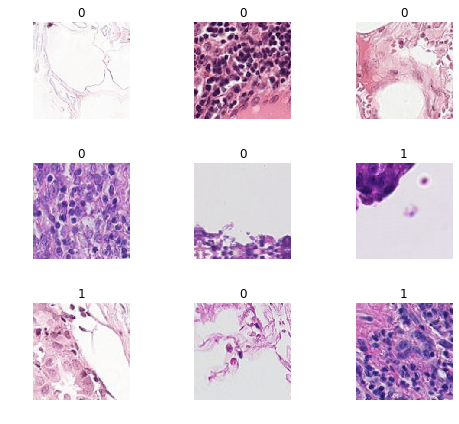

In [29]:
#Take a look at the data: 
data.show_batch(rows = 3, figsize = (7,6))

In [30]:
#Show the number of classes - should be only 2 (tumor "1" or non-tumor "0")
print(data.classes)
len(data.classes)


[0, 1]


2

The next step is to train the model with a Convolutional Neural Network (CNN). We will start with 5 cyles and check the learning rate to ensure the best parameters are chosen. A validation set ensures our model is working correctly. FastAI has a built in feature to create a validation set. It's best to train with one validation set since changing our validation each time can result in an unstable model where we are not sure if a specific dataset is accurate because of the model or the new validation set just happens to match well with the "unknowns".

In [31]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 17972598.65it/s]


In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.243772,0.194594,0.073992,21:52
1,0.202263,0.148955,0.054903,21:23
2,0.185228,0.130096,0.047086,21:16
3,0.173276,0.126098,0.045927,21:39


In [0]:
learn.save('stage-1') #saves the above trained weights in the directory where the data is stored.

## Results of model:

We can see what the confusion matrix looks like, plot out the learning rate to ensure the correct one is being used, and also plot out the instances where the model got labels right and wrong. Looking at the epochs, the error rate is at around 4% after the 4th cycle. The training loss is close to the valid_loss, but not less than it. This metric could be improved with looking that the learning rate. 

In [37]:
interp = ClassificationInterpretation.from_learner(learn) #This is the confusion matrix

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs) #length of validation dataset = length of losses = length of idxs

True

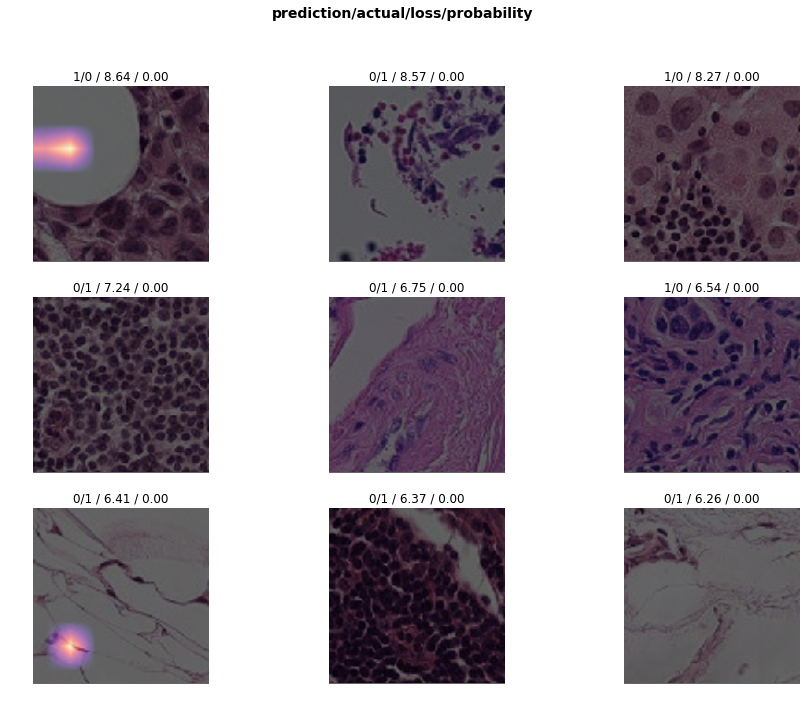

In [38]:
#We can plot the top losses: 
interp.plot_top_losses(9, figsize = (15,11)) #This will show images that have the top losses with their prediction, actual, loss, and probabolity of predicted class

So in this circumstance we will see either a preciction of "0" (normal) or "1" (tumor) and the loss percentage.  

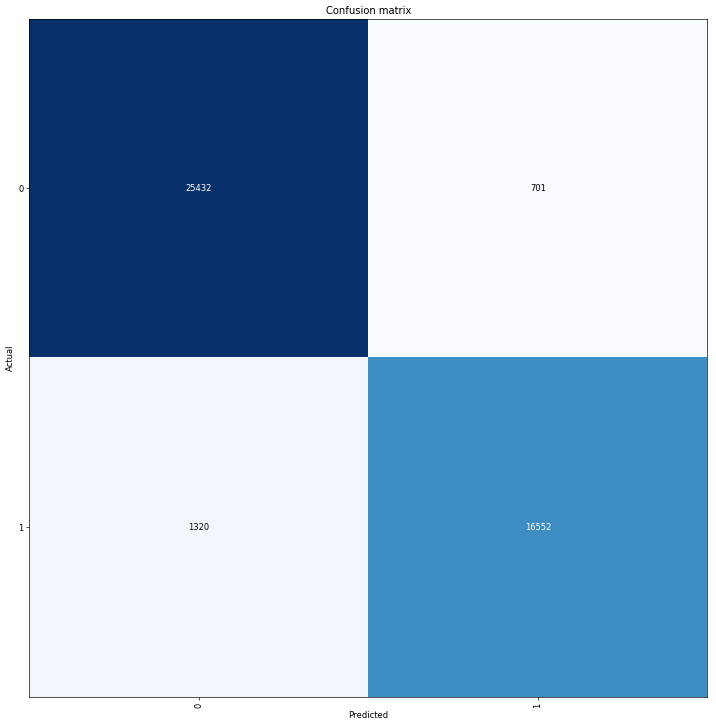

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi = 60) #Confusion Matrix plot

Looking at our confusion matrix, 1,320 images were predicted as "non-tumor", but were actually tumors and 25,432 were correctly predicted as "tumor". For the tumor image sets, 701 "normal" images were incorrectly called as "tumor" and 16,552 images were correctly identified as tumor. 

In [43]:
learn.lr_find() #Learning rate finder - tells us what is the fastest we can train our neural network at without it crashing off the rails and giving us bad error rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


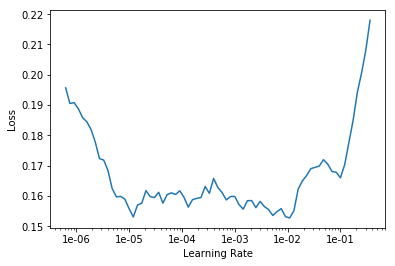

In [44]:
#Check the learning rate by plotting it: 
learn.recorder.plot()

So we can improve our model by setting a learing rate at around 1e-05 (or slice our rates 1e-05 to 1e-02) without compromising accuracy or crashing out the system. Additionally, we can increase the resnet34 to resnet50, but this can put a heavy load on the GPU.

In [46]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.174368,0.164752,0.053517,23:18
1,0.113497,0.087648,0.030701,23:09


Now we can see that the error rate improved to 3% by using the specfic learning rate! 